Udacity <a href="https://learn.udacity.com/nanodegrees/nd025/parts/cd1971/lessons/e3f2b25a-5e8a-404f-a1f8-18c3524ce867/concepts/e3f2b25a-5e8a-404f-a1f8-18c3524ce867-project-rubric">Rubric</a>


In [81]:
# imports
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import (
    SelectFromModel,
    SelectKBest,
    f_regression,
    mutual_info_regression,
    r_regression,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, Ridge, LinearRegression, SGDRegressor, ElasticNet
from sklearn.metrics import (
    make_scorer,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline, make_union
from sklearn.preprocessing import OrdinalEncoder  # for dealing with ordinal categories
from sklearn.preprocessing import (
    TargetEncoder,  # for dealing with high cardinal categories, for now use one-hot encoder
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import LinearSVR

%matplotlib inline


warnings.simplefilter(action="ignore", category=FutureWarning)

In [82]:
# read data
df = pd.read_csv("train.csv")

# Business Understanding

## Project Overview

This project will explore how feature selection and regularization (L1 & L2) methods influence the prediction scores of regression models.

The idea for the project originated with my interest in how models can be fine-tuned to improve their performance.  I wanted to hone in on feature selection and regularization particularly so that their impact could be illustrated.  It is also a good learning opportunity.

The related data set used is the Kaggle Housing dataset <a href="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data">housing data</a>.  The specific datasets used are the train.csv and test.csv.  See the project REAME for instructions on how to obtain them.

## Problem Statement

The problem in the Kaggle housing dataset is to predict what price a house sold for using the available features.  This could be useful information for a potential home buyer.  

The focus for this workbook however will be to use the dataset to explore how various feature selection and regularization (L1 & L2) methods influence predicted housing prices when applying regression models.  

In the end a model will be chosen to measure against the test.csv set.  But over the course of the project several key domain questions will be explored.

Questions to be answered in this project:
* What is the prediction score of a baseline regression model with no feature selection or regularization using:
    * all original features? i.e. the case of no feature selection.
    * only all PCA components of numerical features? to gauge how PCA components alone shape the prediction. 
    * all features + all PCA components? to see how all of our base features + newly created PCA components perform with zero feature selection. 
<br>
<br>
* For each model above:
    * First, test the 3 baseline cases as described above. 
    * Next, apply various feature selection/regularization algorithms and compare prediction scores with baseline data.
<br>
<br>
* Regression models to be tested with the above procedure:
    * Simple Linear Regression
    * Ridge
    * SGDRegressor
    * Lasso
    * ElasticNet
<br>
<br>
* Which model performed the best overall across all tested models? Use this model as the final model to evaluate the test.csv
<br>
<br>
* What insights can be made regarding how feature selection has impacted our prediction scores?
<br>
<br>
My expected solution is that the best performing model overall (as measured using the cross-validation scores) will be 1) a model that is not the Simple Linear Regression model and 2) a model which applies a feature selection or a L1/L2 regularization algorithm that picks a mix of PCA components + original features.  I believe this will be the case because models not using PCA will most likely over-fit the training data and that usually means the final model will have a worse score due to the model "chasing noise" or "memorizing" the training data.  Those types of models tend to perform poorly on new unseen data.  I also believe a model besides Simple Linear Regression may perform better simply because some of the other models may be a bit more flexible and fit the data better.

## Metric

The metric that will be used to evaluate all models is the Root Mean Squared Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price.  As Kaggle notes taking the logs means that the errors in predicting expensive houses and cheap houses will affect the results equally.

A model with a lower RMSE (lower is better) will mean that the average amount of difference between the predicted housing price and the actual housing price will be smaller.  So the metric seems to be appropriate for this context.  I will also be able to compare my results to others who have submitted their results on Kaggle's website.  

# Data Understanding

View the top few rows of the data

In [83]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Explore the numeric variables

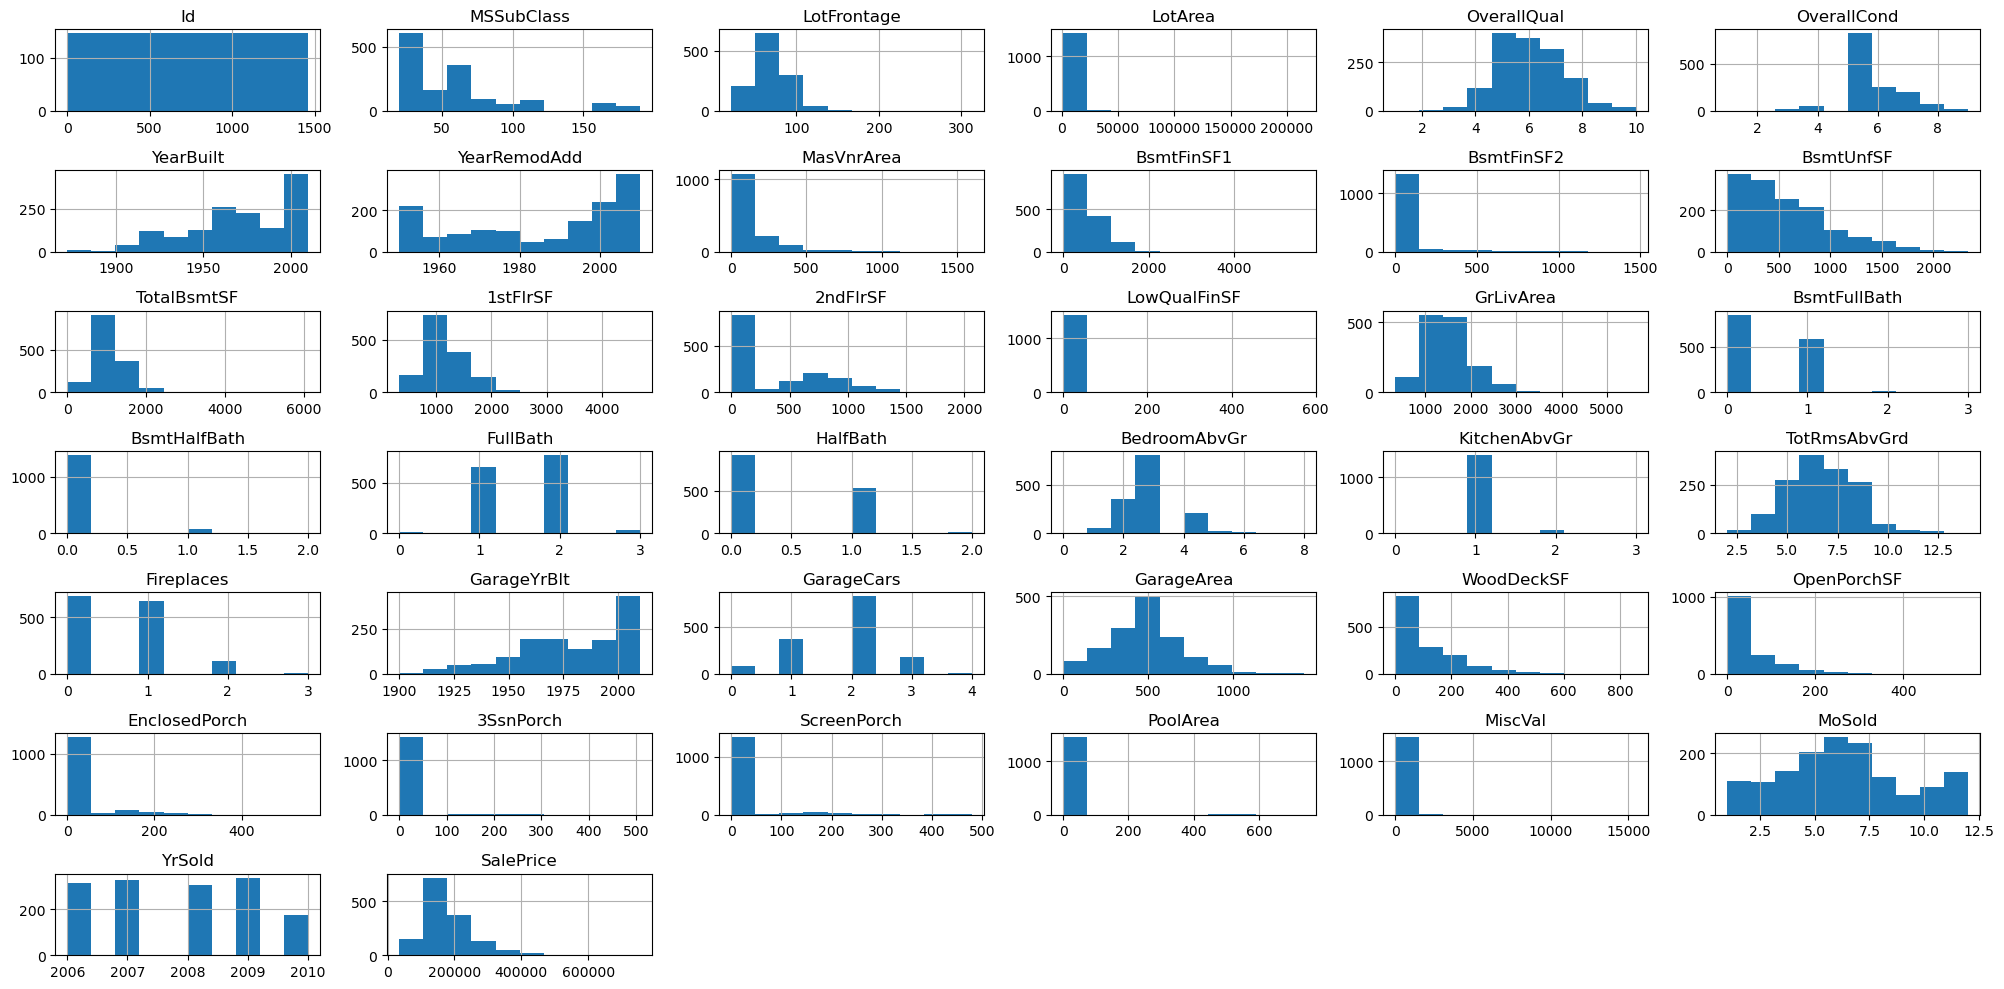

In [84]:
df.hist(figsize=(20, 10))
plt.tight_layout()

General Observations:
* Sales data is roughly between 2006 and 2010.
* More houses were sold in the summer months.
* Most houses are between 1000 - 2000 square feet.
* Most houses were built after 1950.

Take a look at the correlation of the numeric values vs. the sale price

In [85]:
corr = df.corr(numeric_only=True)
corr.style.background_gradient(cmap="coolwarm", axis=None)

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,1.000000,0.011156,-0.010601,-0.033226,-0.028365,0.012609,-0.012713,-0.021998,-0.050298,-0.005024,-0.005968,-0.007940,-0.015415,0.010496,0.005590,-0.044230,0.008273,0.002289,-0.020155,0.005587,0.006784,0.037719,0.002951,0.027239,-0.019772,0.000072,0.016570,0.017634,-0.029643,-0.000477,0.002889,-0.046635,0.001330,0.057044,-0.006242,0.021172,0.000712,-0.021917
MSSubClass,0.011156,1.000000,-0.386347,-0.139781,0.032628,-0.059316,0.027850,0.040581,0.022936,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,0.085072,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotFrontage,-0.010601,-0.386347,1.000000,0.426095,0.251646,-0.059213,0.123349,0.088866,0.193458,0.233633,0.049900,0.132644,0.392075,0.457181,0.080177,0.038469,0.402797,0.100949,-0.007234,0.198769,0.053532,0.263170,-0.006069,0.352096,0.266639,0.070250,0.285691,0.344997,0.088521,0.151972,0.010700,0.070029,0.041383,0.206167,0.003368,0.011200,0.007450,0.351799
LotArea,-0.033226,-0.139781,0.426095,1.000000,0.105806,-0.005636,0.014228,0.013788,0.104160,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,-0.024947,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,-0.028365,0.032628,0.251646,0.105806,1.000000,-0.091932,0.572323,0.550684,0.411876,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.547766,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,0.012609,-0.059316,-0.059213,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.128101,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.324297,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,-0.012713,0.027850,0.123349,0.014228,0.572323,-0.375983,1.000000,0.592855,0.315707,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.825667,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,-0.021998,0.040581,0.088866,0.013788,0.550684,0.073741,0.592855,1.000000,0.179618,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.642277,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
MasVnrArea,-0.050298,0.022936,0.193458,0.104160,0.411876,-0.128101,0.315707,0.179618,1.000000,0.264736,-0.072319,0.114442,0.363936,0.344501,0.174561,-0.069071,0.390857,0.085310,0.026673,0.276833,0.201444,0.102821,-0.037610,0.280682,0.249070,0.252691,0.364204,0.373066,0.159718,0.125703,-0.110204,0.018796,0.061466,0.011723,-0.029815,-0.005965,-0.008201,0.477493
BsmtFinSF1,-0.005024,-0.069836,0.233633,0.214103,0.239666,-0.046231,0.249503,0.128451,0.264736,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.153484,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451

General Observations:
* Sales Price looks to be correlated with:
    * OverallQual: Rates the overall material and finish of the house. Correlation is ~80% which seems significant.
    * GrLivArea: Above grade (ground) living area square feet.
    * Other features related to square feet like GarageCars, GarageArea, Total basement sq ft, etc...
 
The above correlations make a lot of sense.  It should be useful to create some latent features with PCA.  This will be explored more later.

Check for outlier sale price

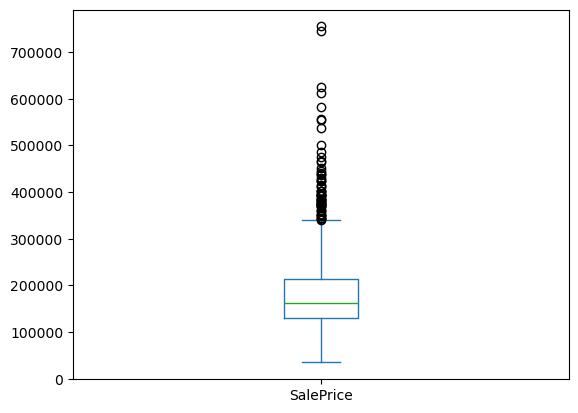

In [86]:
df.plot(y="SalePrice", kind="box");

There are two homes above 700K but that doesn't seem out of the norm for the housing market, so those will be left in.  This data distribution appears skewed.  It makes sense that the data would be lognormally distributed since negative home prices don't make sense.  Let's look at the original distribution and the log-transformed distribution.

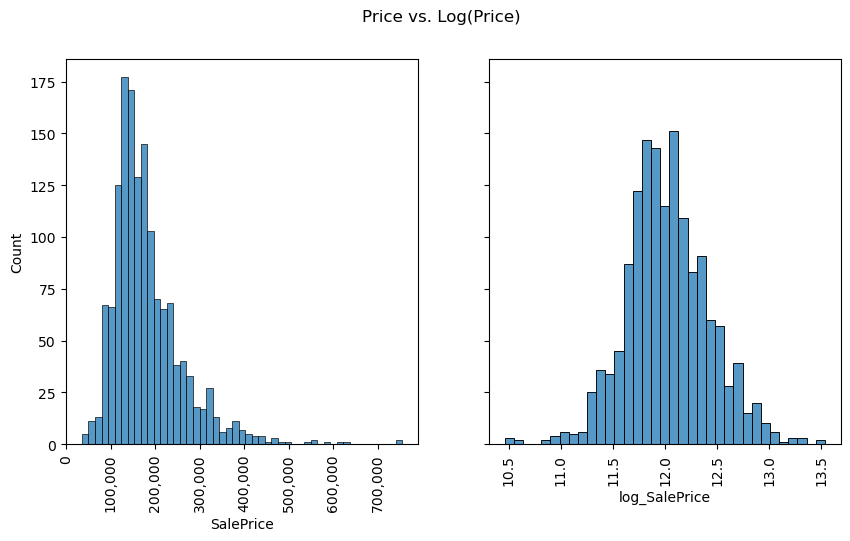

In [87]:
# first let's add the log sale price
df["log_SalePrice"] = df["SalePrice"].apply("log")

# graph both
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
sns.histplot(df, x="SalePrice", ax=axs[0])
sns.histplot(df, x="log_SalePrice", ax=axs[1])
fig.suptitle("Price vs. Log(Price)")
axs[0].tick_params(axis="x", labelrotation=90)
axs[1].tick_params(axis="x", labelrotation=90)
formatter = ticker.StrMethodFormatter("{x:,.0f}")
axs[0].xaxis.set_major_formatter(formatter)

Due to the skewed SalePrice distribution the log of the sale price will be the feature used for predicting,

## Explore the categorical features

In [88]:
non_numeric_cols = df.select_dtypes(exclude="number").columns

In [89]:
# print some top info for each of the non-numeric columns
df_len = df.shape[0]
for col in df[non_numeric_cols]:
    names = list(df[col].value_counts().index)
    sliced_names = [str(name)[:25] for name in names]
    values = list(df[col].value_counts())
    print(f"{df[col].name}: {list(zip(sliced_names, values))}")

MSZoning: [('RL', 1151), ('RM', 218), ('FV', 65), ('RH', 16), ('C (all)', 10)]
Street: [('Pave', 1454), ('Grvl', 6)]
Alley: [('Grvl', 50), ('Pave', 41)]
LotShape: [('Reg', 925), ('IR1', 484), ('IR2', 41), ('IR3', 10)]
LandContour: [('Lvl', 1311), ('Bnk', 63), ('HLS', 50), ('Low', 36)]
Utilities: [('AllPub', 1459), ('NoSeWa', 1)]
LotConfig: [('Inside', 1052), ('Corner', 263), ('CulDSac', 94), ('FR2', 47), ('FR3', 4)]
LandSlope: [('Gtl', 1382), ('Mod', 65), ('Sev', 13)]
Neighborhood: [('NAmes', 225), ('CollgCr', 150), ('OldTown', 113), ('Edwards', 100), ('Somerst', 86), ('Gilbert', 79), ('NridgHt', 77), ('Sawyer', 74), ('NWAmes', 73), ('SawyerW', 59), ('BrkSide', 58), ('Crawfor', 51), ('Mitchel', 49), ('NoRidge', 41), ('Timber', 38), ('IDOTRR', 37), ('ClearCr', 28), ('StoneBr', 25), ('SWISU', 25), ('MeadowV', 17), ('Blmngtn', 17), ('BrDale', 16), ('Veenker', 11), ('NPkVill', 9), ('Blueste', 2)]
Condition1: [('Norm', 1260), ('Feedr', 81), ('Artery', 48), ('RRAn', 26), ('PosN', 19), ('RRAe

General Observations:
* It looks like some columns have high cardinality (Neighborhood, Exterior1st, Exterior2nd).
* Some features don't appear too informative (Street, Utilities) as almost 100% of the values are only in one category.
* It looks like for many of the features the categories are very skewed to the top value (where the second highest value in a column is almost a factor of 10 lower than the top value).
* Some non-numeric features appear ordinal (like BsmtQal and BsmtCond).  These could be re-encoded to numerical.

How many categories have more than 3 values (not including n/a).

In [90]:
greater = 0
total = 0
for col in df[non_numeric_cols]:
    num = df[col].value_counts().shape[0]
    if num > 3:
        greater += 1
    total += 1

print(
    f"{greater} non-numeric columns out of {total} have more than 3 categories.  This is a ratio of {greater/total:.2%}."
)

34 non-numeric columns out of 43 have more than 3 categories.  This is a ratio of 79.07%.


Due to the high number of columns with more than 3 categories, target encoding will be used for simplicity.  Target encoding uses the target mean conditioned on the categorical feature for encoding un-ordered categories.  This is useful for features with high cardinality.  See scikit-learn discussion <a href="https://scikit-learn.org/stable/modules/preprocessing.html#target-encoder">here.</a>



# Data Preparation

## Identify columns with missing data

In [91]:
# ensure all missing data coded the same
# fill all missing data with np.nan
df.fillna(np.nan, inplace=True)

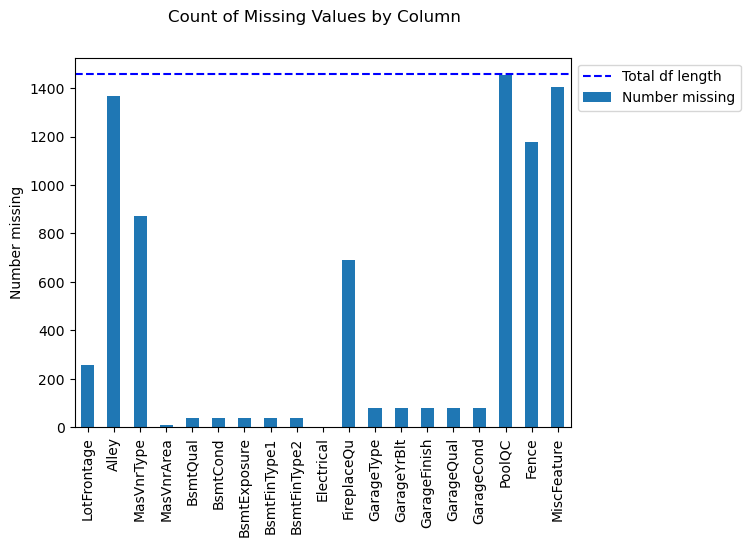

In [92]:
# identify and plot
missing_cols = df.columns[df.isna().any()].to_list()

fig, ax = plt.subplots()
df[missing_cols].isna().sum().plot.bar(ax=ax, label="Number missing")
ax.set_ylabel("Number missing")
fig.suptitle("Count of Missing Values by Column")
plt.axhline(y=df.shape[0], color="b", linestyle="--", label="Total df length")
ax.legend(bbox_to_anchor=(1, 1));

Based on the above it looks like dropping columns with more than 600 missing values might be a good thing to do.

However, when reading the data description, we see the following for PoolQC: NA = No Pool

So, in this case a value of NA is actually informative in that it means there is no pool.  This is different from a typical na value as typically na would mean we don't know anything about the pool value.  But in this case we know NA means there is no pool.  This information should be retained.

After reading through more descriptions we learn the same can be said of the following categories with > 600 missing values:
Alley, FireplaceQu, PoolQC, Fence, MiscFeature.

MasVnrType is a bit confusing as it uses the term None instead of NA.  Due to this confusion I am going to assume NA is truly missing to be safe.

Therefore the only column really worth dropping with >600 missing values is the MasVnrType field.

In [93]:
df.drop(columns=["MasVnrType"], inplace=True)

Now let's discuss the columns with smaller number of missing values.  Specifically the columns related to the Basement and Garage.  
The data descriptions for categorical + ordinal columns GarageType, GarageFinish, GarageQual, GarageCond, BasmtQual, BsmtCond, BsmtExposure all say that the NA values mean there is no Garage or Basement.  Therefore these values will be treated as their own category during Target Encoding.

Per Sklearn, "TargetEncoder considers missing values, such as np.nan or None, as another category and encodes them like any other category. Categories that are not seen during fit are encoded with the target mean, i.e. target_mean_." <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html">Target Encoding<a/>

Numerical columns BsmtFinType1, BsmtFinType with NA values will be also be assumed to be houses with no basement for simplicity. These will be imputed with 0 as in 0 sq ft. MasVnrArea will be treated the same for simplicity.

Due to the low number of na values in Electrical (1 row), this will be left to be handled by the Target Encoder.

## Identify rows with missing values

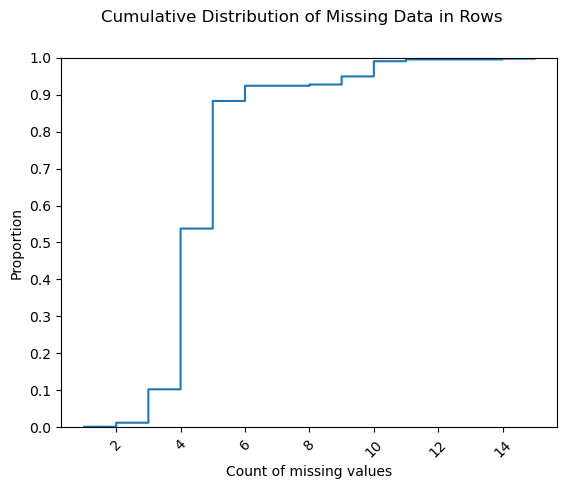

In [94]:
# identify and plot missing rows
missing_row = df.shape[1] - df.count(axis=1)  # number of missing values per row

fig, ax = plt.subplots()
sns.ecdfplot(missing_row, ax=ax)
plt.xticks(rotation=45)
ax.set_yticks(list(np.arange(0.0, 1.1, 0.1)))
plt.suptitle("Cumulative Distribution of Missing Data in Rows")
ax.set_xlabel("Count of missing values");

There are not many rows with lots of missing values.  Therefore these will be left as is and their values will be imputed as described above.  The chart above shows that ~90% of rows are missing 5 or fewer values. 

# Data Modeling

## Create X and y matrices

In [95]:
y = df["SalePrice"].copy()
X = df.drop(
    columns=["SalePrice", "log_SalePrice", "Id"]
).copy()  # drop the log sale price and handle that transformation via the model pipeline, we also don't need Id

## Define the numeric, categorical, and ordianal features

In [96]:
numeric_features = [
    "LotFrontage",
    "LotArea",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "BsmtFinSF1",  
    "BsmtFinSF2",  
    "BsmtUnfSF",  
    "TotalBsmtSF",  
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "TotRmsAbvGrd",
    "Fireplaces",
    "GarageYrBlt", 
    "GarageCars",  
    "GarageArea",  
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "MiscVal",
    "MoSold",
    "YrSold",
]

categorical_features = [
    "MSSubClass",  # was numeric but by description should be categorical
    "Alley",
    "MSZoning",
    "Street",
    "LotShape",
    "LandContour",
    "Utilities",
    "LotConfig",
    "LandSlope",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "ExterQual",
    "ExterCond",
    "Foundation",
    "Heating",
    "CentralAir",
    "Electrical",
    "Functional",
    "GarageType",
    "GarageFinish",
    "PavedDrive",
    "Fence",
    "SaleType",
    "MiscFeature",
    "SaleCondition",
]

# ordinal features will be encoded, so initially need to define the categories for each feature
ordinal_features_dict = {
    "FireplaceQu": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "PoolQC": ["Fa", "TA", "Gd", "Ex", np.nan],
    "BsmtQual": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "BsmtCond": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "BsmtExposure": ["No", "Mn", "Av", "Gd", np.nan],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ", np.nan],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ", np.nan],
    "HeatingQC": ["Po", "Fa", "TA", "Gd", "Ex"],
    "KitchenQual": ["Po", "Fa", "TA", "Gd", "Ex"],
    "GarageQual": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
    "GarageCond": ["Po", "Fa", "TA", "Gd", "Ex", np.nan],
}

ordinal_features = list(ordinal_features_dict.keys())

## Build a prepocessing pipeline

### Some Setup: Splitting the data and creating some helper functions

Make a scorer that can be used to evaluate the models. This will be the RMSE of the log prediction vs the log actual housing price as discussed earlier.

In [97]:
# custom scorer: Lower is better
def RMSE_log(y_true, y_pred):
    score = root_mean_squared_error(np.log(y_true), np.log(y_pred))
    return score


myscore = make_scorer(RMSE_log)

split the data

In [98]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=38
)

Make a function that can take 3 pipelines (original features, pca only, orginal features + pca) and a regressor and return the results.



In [99]:
def run_model(X, y, pipeline_list, regressor, scorer, verbose=0, name=None):
    """
    This function will take the 3  cases (all features, nummeric PCA, and all features + numeric PCA) plus a regressor
    and return their CV and training score for each.

    Parameters:
        - X: the X matrix to be evaluated.
        - y: the y matrix to be evaluated.
        - pipeline list: A list of sklearn pipelines in the order of all 1) features  2) numeric PCA and 3) all features + numeric PCA
        - regressor: the Sklearn regressor object to be used to create the prediction.
        - scorer: the custom scorer used to create the CV and training scores.
        - verbose: the verbose level to be returned by the fit SKlearn fit method
        - name: this is the name (str) of the type of run. to be used for chart labels later.

    Returns:
        - training_score_list: The RMSE of the log prediction using the training data. 
        - CV_score_list: the RMSE of the log prediction using cross-validation.    
        - train_score_stdev_list: standard deviation of the training scores.
        - C_score_stdev_list: standard deviation of the cross-validation scores.
        - estimators_list: A list of which estimators were fit in the function.
        - name: this is the name (str) of the type of run. to be used for chart labels later.
    """

    # create the transform for the y value
    regressor_transform = TransformedTargetRegressor(
        regressor=regressor, func=np.log, inverse_func=np.exp
    )

    (
        training_score_list,
        CV_score_list,
        train_score_stdev_list,
        CV_score_stdev_list,
        estimators_list,
    ) = (
        [],
        [],
        [],
        [],
        [],
    )
    print(f"Evaluating Model: {name}")
    for i, pipeline in enumerate(pipeline_list):
        clf = make_pipeline(pipeline, regressor_transform)

        # score the model
        cv_results = cross_validate(
            clf,
            X,
            y,
            cv=5,
            scoring=scorer,
            return_train_score=True,
            verbose=verbose,
            return_estimator=True,
        )

        CV_score_list.append(np.mean(cv_results["test_score"]))
        CV_score_stdev_list.append(np.std(cv_results["test_score"]))
        training_score_list.append(np.mean(cv_results["train_score"]))
        train_score_stdev_list.append(np.std(cv_results["train_score"]))
        estimators_list.append(cv_results["estimator"])

    return (
        training_score_list,
        CV_score_list,
        train_score_stdev_list,
        CV_score_stdev_list,
        estimators_list,
        name,
    )

Create a function to store the outputs in a dataframe

In [100]:
def store_output(
    results_df, model_name, pipe_names, train_scores, CV_scores, train_std, CV_std
):
    """
    Take the results from a test iteration and append them to the results dataframe

    Parameters:
        - results_df: the dataframe which results will be appended to.
        - model_name: the name of the model being evaluated (ex. "SGD regression alpha=1 penalty=L1" )
        - pipe_names: the list of strings that describe the number of features in the model (all original features, numeric PCA features only, all original + numeric PCA features)
        - train_scores: The RMSE of the log prediction using the training data.
        - CV_scores: the RMSE of the log prediction using cross-validation.
        - train_std: standard deviation of the training scores.
        - CV_std:  standard deviation of the cross-validation scores.

    Returns:
        - The appended dataframe

    """

    # write outputs to dataframe
    index_names = [[model_name], pipe_names]
    index = pd.MultiIndex.from_product(index_names, names=["TestType", "FeaturesUsed"])

    data = {
        "train_scores": train_scores,
        "CV_scores": CV_scores,
        "train_std": train_std,
        "CV_std": CV_std,
    }

    result = pd.DataFrame(data=data, index=index)
    results = pd.concat([results_df, result])
    return results

Create a function that can run multiple models and return a dataframe with the results

In [101]:
# write a function to iterate over models and store their results
def iterate_over_models(regressor_tests, names, pipes, pipe_names, X_train, y_train, myscore):
    """
    This function will take in a list of regressors, iterate over and fit each model, and store the CV score and train score for each in a result data frame.

    Parameters:
        regressor_tests: A list of regressor objects to fit
        names: A list of strings describing the regression models
        pipes: A list of sklearn pipelines
        pipe_names: the list of strings that describe the number of features in the model (all original features, numeric PCA features only, all original + numeric PCA features)
        X_train: the X training matrix
        y_train: the y training matrix
        myscore: the scorer used for scoring the model.
        
    Returns:
        results: A results dataframe containing the training and CV scores.
    """
    results = pd.DataFrame()

    for regressor, name in zip(regressor_tests, names):
        train_scores, CV_scores, train_std, CV_std, estimators, name = run_model(
            X_train, y_train, pipes, regressor, myscore, name=name
        )

        # write outputs to dataframe
        results = store_output(
            results, name, pipe_names, train_scores, CV_scores, train_std, CV_std
        )

    return results

Create a function that can plot the results

In [102]:
# write a function to plot the results
def plot_results(results, names, pipe_names):
    """
    This function will take the results dataframe and plot the training scores and CV scores of the fitted models as a bar chart.

    Parameters:
        results: the results dataframe containing the train scores and CV scores
        names: the list of strings that describe what regressors have been fitted.
        pipe_names: the list of strings that describe the number of features in the model (all original features, numeric PCA features only, all original + numeric PCA features)

    Returns:
        Nothing, but a plot is displayed.
    """

    # data dictionaries used for plotting
    cv_scores_dict = {name: results["CV_scores"].loc[name].values for name in names}
    cv_std_dict = {name: results["CV_std"].loc[name].values for name in names}

    train_scores_dict = {
        name: results["train_scores"].loc[name].values for name in names
    }
    train_std_dict = {name: results["train_std"].loc[name].values for name in names}

    x = np.arange(len(pipe_names))  # label locations
    width = 0.1  # width of the bars
    multiplier = 0

    fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

    for test in names:
        offset = width * multiplier
        rects_cv = axs[1].bar(
            x + offset, cv_scores_dict[test], width, label=test, yerr=cv_std_dict[test]
        )
        rects_train = axs[0].bar(
            x + offset,
            train_scores_dict[test],
            width,
            label=test,
            yerr=train_std_dict[test],
        )
        labels_cv = axs[1].bar_label(rects_cv, padding=3, fmt="{:.3}")
        labels_train = axs[0].bar_label(rects_train, padding=3, fmt="{:.3}")
        [label.set_rotation(90) for label in labels_cv]
        [label.set_rotation(90) for label in labels_train]
        multiplier += 1

    axs[1].set_ylabel("RMSE")
    axs[0].set_ylabel("RMSE")
    axs[1].set_title("CV Scores")
    axs[0].set_title("Train Scores")
    axs[0].set_xticks(x + width, pipe_names)
    axs[1].set_xticks(x + width, pipe_names)
    axs[0].legend(loc="upper right")

### Create the pipelines to tranform/clean the training data

Case for only the original features

In [103]:
# for the ordinal features we will need a list of the categories so the order of the values can be defined.
categories = list(ordinal_features_dict.values())

# pipeline to for transforming original features only
features_only = make_pipeline(
    make_column_transformer(
        (
            SimpleImputer(strategy="constant", fill_value=0),
            numeric_features,
        ),  # fill 0 as described in above missing data section
        (
            TargetEncoder(categories="auto", target_type="continuous", random_state=41),
            categorical_features,
        ),
        (
            OrdinalEncoder(
                categories=categories, encoded_missing_value=-1
            ),  # encode na values as -1 as na values mean the absence of the basement, garage, etc...
            ordinal_features,
        ),
    ),
    StandardScaler(),
)

Case for only PCA transformed numerical/ordinal columns

In [104]:
numerical_features_PCA = make_pipeline(
    make_column_transformer(
        (SimpleImputer(strategy="constant", fill_value=0), numeric_features),
        (
            OrdinalEncoder(categories=categories, encoded_missing_value=-1),
            ordinal_features,
        ),
        remainder="drop",  # drop the categorical features
    ),
    StandardScaler(),
    PCA(
        random_state=41,
    ),
)

Case for all original features + all numeric/ordinal PCA transformed features

In [105]:
combined_features = make_union(features_only, numerical_features_PCA)

## Fit models and return results

In [106]:
# Create a list of the pipelines and their names so that these can be passed to a function to fit various regression models
pipes = [features_only, numerical_features_PCA, combined_features]
pipe_names = ["features_only", "numeric_PCA", "combined"]

Evaluating Model: Baseline Regression
Evaluating Model: LR - 3 Best
Evaluating Model: LR - 5 Best
Evaluating Model: LR - 10 Best


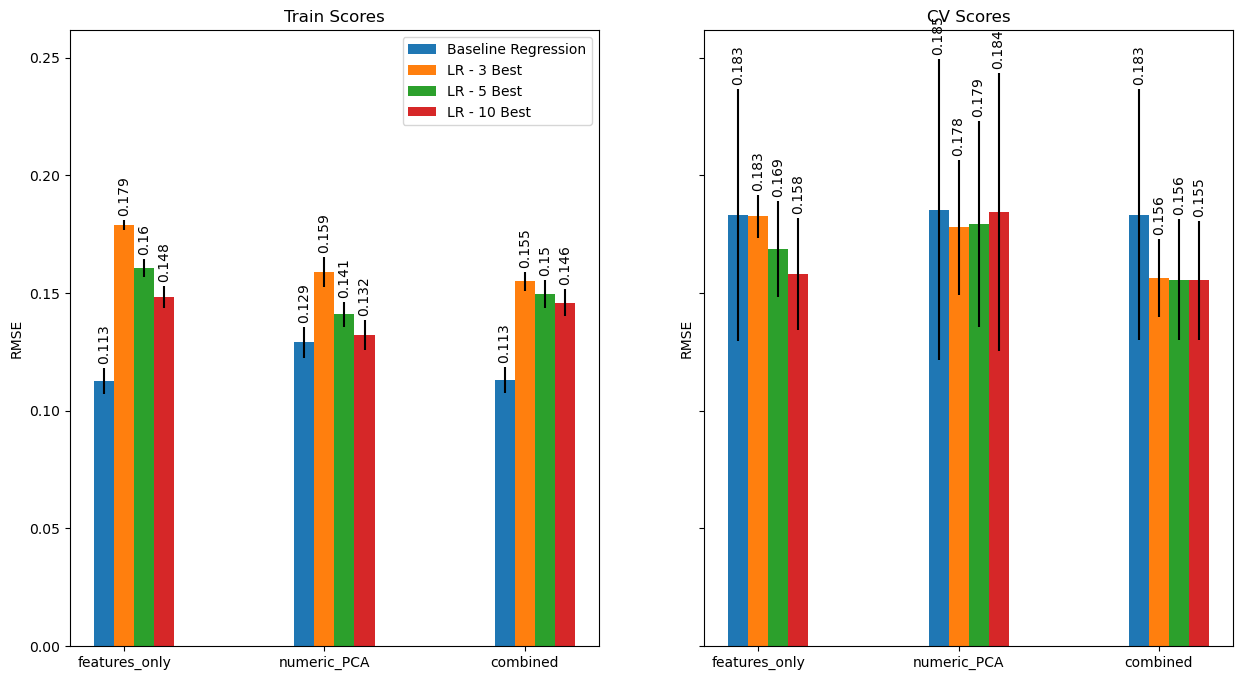

In [107]:
# iterate over models
# this will be simple linear regression along with some selectkbest
regressor_tests = [
    LinearRegression(),
    make_pipeline(SelectKBest(f_regression, k=3), LinearRegression()),
    make_pipeline(SelectKBest(f_regression, k=10), LinearRegression()),
    make_pipeline(SelectKBest(f_regression, k=20), LinearRegression()),
]
names = [
    "Baseline Regression",
    "LR - 3 Best",
    "LR - 5 Best",
    "LR - 10 Best",
]

results = iterate_over_models(regressor_tests, names, pipes, pipe_names, X_train, y_train, myscore)
plot_results(results, names, pipe_names)

Evaluating Model: Baseline Regression
Evaluating Model: Lasso alpha=1.0
Evaluating Model: Lasso alpha=0.1
Evaluating Model: Lasso alpha=0.01


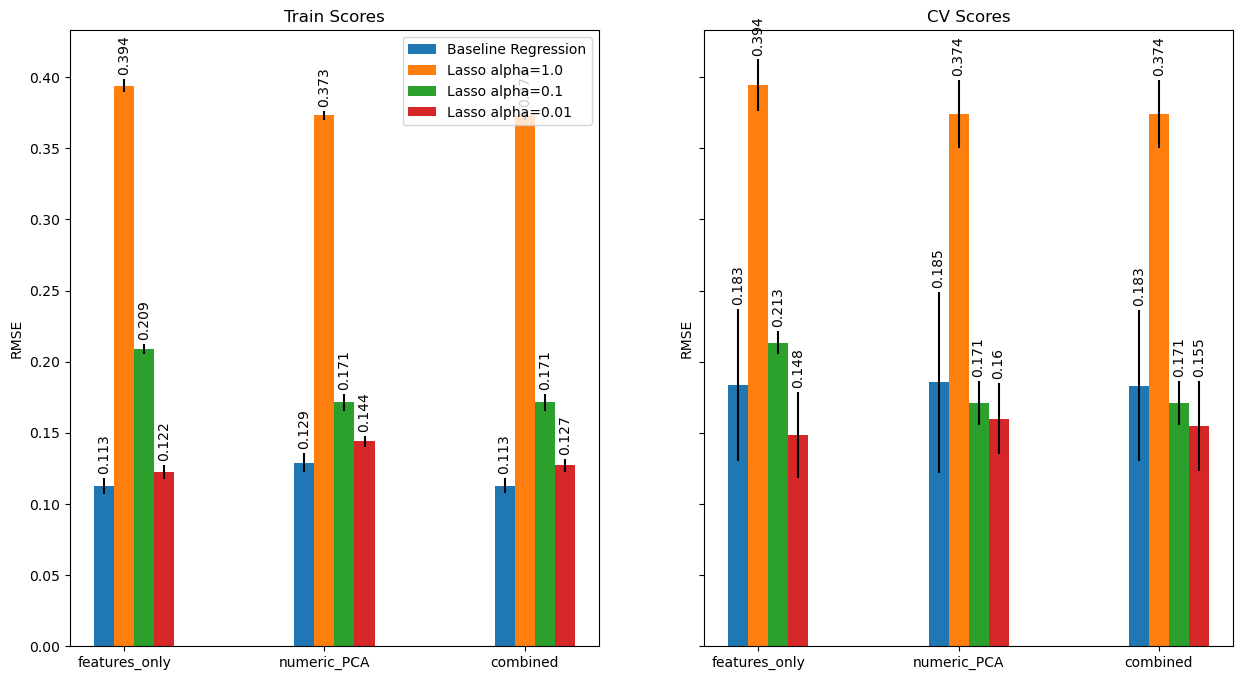

In [108]:
# iterate over models
# this will be Lasso Regression.  For the baseline use LinearRegression as Lasso without regularization reduces to baseline simple linear regression
regressor_tests = [
    LinearRegression(),
    Lasso(alpha=1.0),
    Lasso(alpha=0.1),
    Lasso(alpha=0.01),
]
names = [
    "Baseline Regression",
    "Lasso alpha=1.0",
    "Lasso alpha=0.1",
    "Lasso alpha=0.01",
]

results = iterate_over_models(regressor_tests, names, pipes, pipe_names, X_train, y_train, myscore)
plot_results(results, names, pipe_names)

Evaluating Model: Baseline Regression
Evaluating Model: Ridge alpha=1.0
Evaluating Model: Ridge alpha=1,000
Evaluating Model: Ridge alpha=10,000


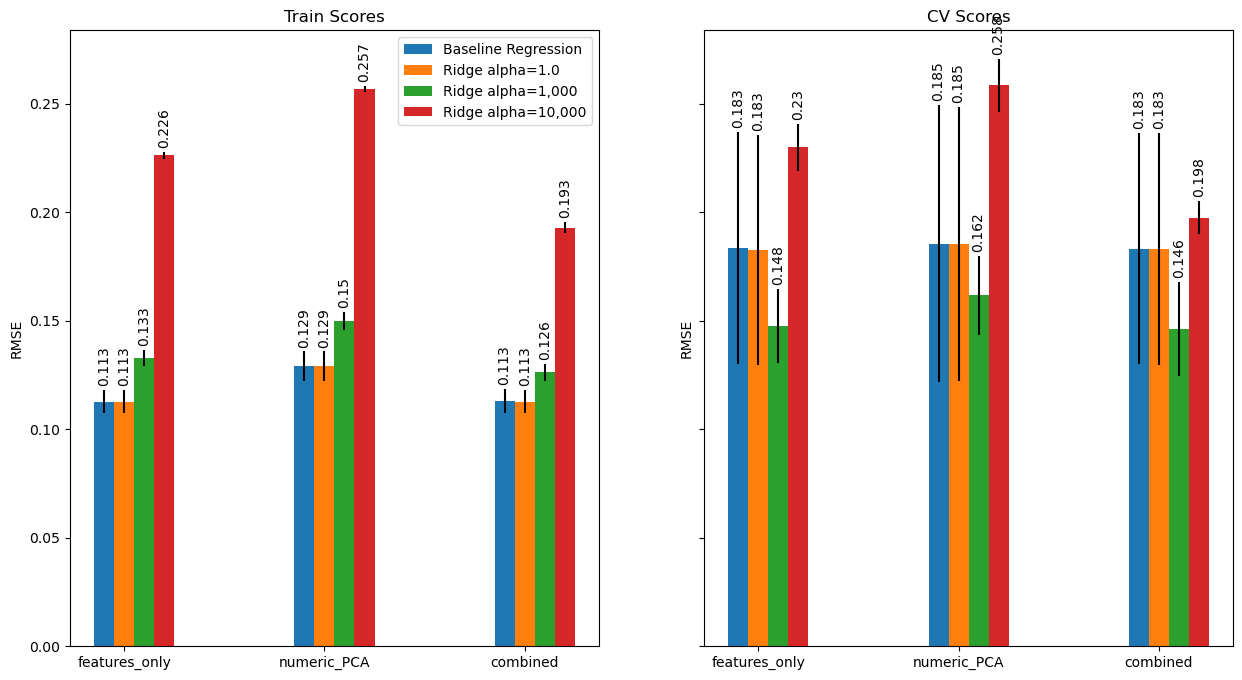

In [130]:
# iterate over models
# this will be Ridge Regression.  For the baseline use LinearRegression as Ridge without regularization reduces to baseline simple linear regression
regressor_tests = [
    LinearRegression(),
        Ridge(alpha=1.0),
    Ridge(alpha=1000.0),
    Ridge(alpha=10000.0),
]
names = [
    "Baseline Regression",
    "Ridge alpha=1.0",
    "Ridge alpha=1,000",
    "Ridge alpha=10,000",
]

results = iterate_over_models(regressor_tests, names, pipes, pipe_names, X_train, y_train, myscore)
plot_results(results, names, pipe_names)

Evaluating Model: Baseline Regression
Evaluating Model: ElasticNet alpha=1.0
Evaluating Model: ElasticNet alpha=0.1
Evaluating Model: ElasticNet alpha=0.01


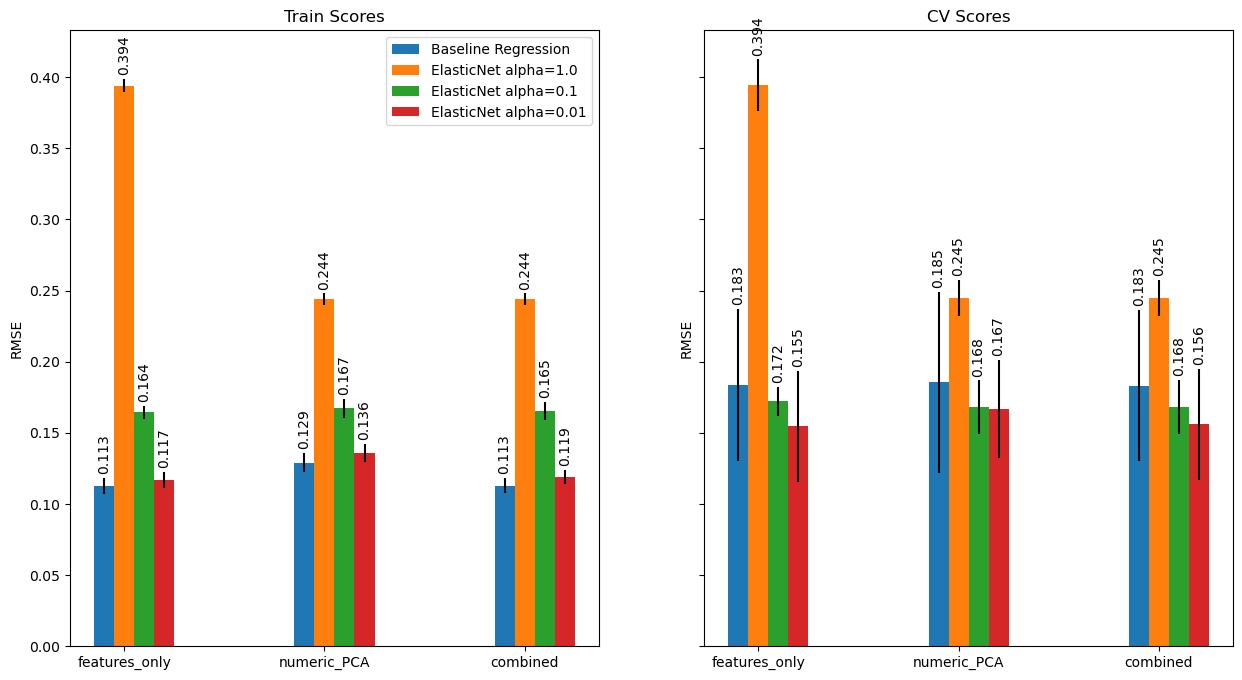

In [110]:
# iterate over models
# this will be ElasticNet Regression.  For the baseline use LinearRegression as ElasticNet without regularization reduces to baseline simple linear regression
regressor_tests = [
    LinearRegression(),
    ElasticNet(alpha=1.0),
    ElasticNet(alpha=0.1),
    ElasticNet(alpha=0.01),
]
names = [
    "Baseline Regression",
    "ElasticNet alpha=1.0",
    "ElasticNet alpha=0.1",
    "ElasticNet alpha=0.01",
]

results = iterate_over_models(regressor_tests, names, pipes, pipe_names, X_train, y_train, myscore)
plot_results(results, names, pipe_names)

Evaluating Model: Baseline SGDRegressor
Evaluating Model: SGD alpha=1.0 L1
Evaluating Model: SGD alpha=0.1 L1
Evaluating Model: SGD alpha=0.01 L1
Evaluating Model: SGD alpha=1.0 L2
Evaluating Model: SGD alpha=0.1 L2
Evaluating Model: SGD alpha=0.01 L2


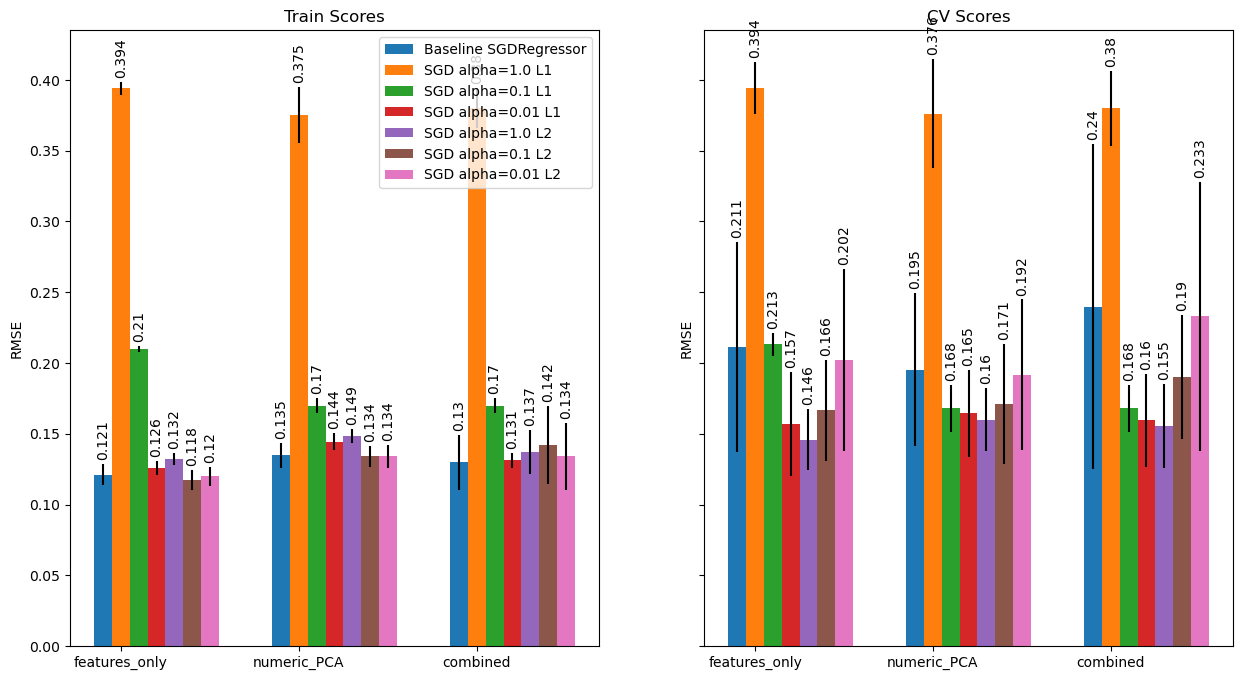

In [129]:
# iterate over models
# try gradient descent, when penalty=None there is no feature selection or regularization, so this would be the baseline.
regressor_tests = [
    SGDRegressor(penalty=None, random_state=41),
    SGDRegressor(penalty='l1', alpha=1.0, random_state=41),
    SGDRegressor(penalty='l1', alpha=0.1, random_state=41),
    SGDRegressor(penalty='l1', alpha=0.01, random_state=41),
    SGDRegressor(penalty='l2', alpha=1.0, random_state=41),
    SGDRegressor(penalty='l2', alpha=0.1, random_state=41),
    SGDRegressor(penalty='l2', alpha=0.01, random_state=41),
]
names = [
    "Baseline SGDRegressor",
    "SGD alpha=1.0 L1",
    "SGD alpha=0.1 L1",
    "SGD alpha=0.01 L1",
    "SGD alpha=1.0 L2",
    "SGD alpha=0.1 L2",
    "SGD alpha=0.01 L2",
]

results = iterate_over_models(regressor_tests, names, pipes, pipe_names, X_train, y_train, myscore)
plot_results(results, names, pipe_names)

# Result Evaluation

From the above 4 regression models tested, it appears that all 4 models in the end performed about the same.  Apart from Ridge Regression's best CV score of 0.146, the other three models were all able to score either 0.155 or 0.156. They were all within the same standard deviation band.

I originally predicted that the Simple Linear Regression model would not score as well overall as another more sophisticated model.  However, in the end Simple Linear Regression with some feature selection performed just as well as a more sophisticated model such as SGDRegressor.  I believe this is probably due to the fact that the only parameter I focused on was the feature selection aspect.  The underlying default loss function actually reduces to simpler linear regression for all models.  So with that in mind I suppose it is not surprising that they all performed similarly.  Perhaps if I had also tried tuning some other parameters the results would be a bit different.  

I also had predicted that the best performing models would involve some type of feature selection or regularization (L1/L2) using the "combined" feature set (i.e. all original features + the PCA components).  This turned out to be accurate.  Apart from Ridge Regression the other three models all had a better prediction score with a lower standard deviation as compared to the baseline case.  It appears that the baseline cases were indeed "memorizing" the training data.  This can be seen because the baseline cases tended to have the better score on the training data, but one of the worst scores on the cross-validation set.

Conclusion:
As can be seen in the above visualizations, using feature selection or regularization can greatly improve the prediction power of regression models.  This can be attributed to these models being more robust to new unseen data as compared to the models without feature selection or regularization.  When feature selection is not performed the model tends to over-fit and this can lead to poor results in the general case.  

I found it interesting to see these results in action and it was helpful to focus just on one aspect in order to see it's impact.  It was also interesting that the data using Ridge Regression seemed to be insensitive to values of alpha unless they were quite large.  

Potential for Improvement:
I think this project could be improved in a few ways: 
 - I think it would be interesting to use a different dataset. The kaggle housing dataset is a simplified dataset and could explain why all results were fairly similar.  It would be interesting to test the same ideas on a more complex dataset to see if the results between models differ.
 - I only tested a handful of feature selection algorithms as well as a limited number of parameters for those.  I think this could be expanded to a larger space.  This would be especially interesting if a larger and more complex dataset was tested.  Doing so may show more interesting patterns in the relationship between the feature selection algorithms vs their chosen parameters.
 - I didn't explore which features the feature selection algorithms identified. It would be interesting to compare and contrast which features the different algorithms picked up on.  Were they mostly the same? Or were there some interesting differences?

## check some of the coeffiencts used and the mean/std

In [112]:
train_scores, CV_scores, train_std, CV_std, estimators, name = run_model(
    X_train,
    y_train,
    pipes,
    Lasso(alpha=0.01),
    myscore,
    verbose=3,
)

Evaluating Model: None
[CV] END ..................., score=(train=0.117, test=0.173) total time=   0.1s
[CV] END ..................., score=(train=0.127, test=0.124) total time=   0.1s
[CV] END ..................., score=(train=0.127, test=0.118) total time=   0.0s
[CV] END ..................., score=(train=0.125, test=0.132) total time=   0.0s
[CV] END ..................., score=(train=0.116, test=0.195) total time=   0.0s
[CV] END ..................., score=(train=0.139, test=0.169) total time=   0.0s
[CV] END ..................., score=(train=0.147, test=0.147) total time=   0.0s
[CV] END ..................., score=(train=0.149, test=0.128) total time=   0.0s
[CV] END ..................., score=(train=0.146, test=0.154) total time=   0.0s
[CV] END ..................., score=(train=0.139, test=0.202) total time=   0.0s
[CV] END ..................., score=(train=0.121, test=0.194) total time=   0.1s
[CV] END ..................., score=(train=0.131, test=0.135) total time=   0.1s
[CV] 

In [113]:
# pipeline, model, regressor
estimators[2][0][-1].regressor_.coef_

array([-0.        ,  0.        ,  0.03191544,  0.03479   ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        , -0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.03167387,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
        0.        , -0.        , -0.        ,  0.00238198,  0.        ,
        0.00170238,  0.        ,  0.        , -0.        , -0.        ,
        0.00262858,  0.        ,  0.02891548,  0.00415076,  0.        ,
        0.        , -0.        ,  0.00141688, -0.        ,  0.03260181,
        0.00047108, -0.        ,  0.        , -0.        ,  0.        ,
        0.00083687,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.00159991,  0.        ,  0.00540244,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.00996032,  0.        , -0.0739581 , -0.  

In [114]:
estimators[0][0][0]

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant'),
                                                  ['LotFrontage', 'LotArea',
                                                   'OverallQual', 'OverallCond',
                                                   'YearBuilt', 'YearRemodAdd',
                                                   'MasVnrArea', 'BsmtFinSF1',
                                                   'BsmtFinSF2', 'BsmtUnfSF',
                                                   'TotalBsmtSF', '1stFlrSF',
                                                   '2ndFlrSF', 'LowQualFinSF',
                                                   'GrLivArea', 'BsmtFullBath',
                                                   'BsmtHa...
                                                                              'BLQ',
                                                                              'ALQ',
                                                                              'GLQ',
                                                                              nan],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex'],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex',
                                                                              nan],
                                                                             ['Po',
                                                                              'Fa',
                                                                              'TA',
                                                                              'Gd',
                                                                              'Ex',
                                                                              nan]],
                                                                 encoded_missing_value=-1),
                                                  ['FireplaceQu', 'PoolQC',
                                                   'BsmtQual', 'BsmtCond',
                                                   'BsmtExposure',
                                                   'BsmtFinType1',
                                                   'BsmtFinType2', 'HeatingQC',
                                                   'KitchenQual', 'GarageQual',
                                                   'GarageCond'])])),
                ('standardscaler', StandardScaler())])

In [115]:
# pipeline, model, regressor
features_used = np.where(~np.isclose(estimators[2][0][-1].regressor_.coef_, 0))
estimators[2][0][0].get_feature_names_out()[features_used]

array(['pipeline-1__simpleimputer__OverallQual',
       'pipeline-1__simpleimputer__OverallCond',
       'pipeline-1__simpleimputer__GrLivArea',
       'pipeline-1__simpleimputer__EnclosedPorch',
       'pipeline-1__simpleimputer__ScreenPorch',
       'pipeline-1__targetencoder__MSSubClass',
       'pipeline-1__targetencoder__MSZoning',
       'pipeline-1__targetencoder__Street',
       'pipeline-1__targetencoder__LotConfig',
       'pipeline-1__targetencoder__Neighborhood',
       'pipeline-1__targetencoder__Condition1',
       'pipeline-1__targetencoder__RoofMatl',
       'pipeline-1__targetencoder__CentralAir',
       'pipeline-1__targetencoder__Functional',
       'pipeline-1__targetencoder__SaleCondition',
       'pipeline-1__ordinalencoder__PoolQC', 'pipeline-2__pca0',
       'pipeline-2__pca2', 'pipeline-2__pca4', 'pipeline-2__pca10',
       'pipeline-2__pca17', 'pipeline-2__pca25'], dtype=object)

In [116]:
# pipeline, model, regressor
features_used = np.where(~np.isclose(estimators[0][0][-1].regressor_.coef_, 0))
estimators[0][0][0].get_feature_names_out()[features_used]

array(['simpleimputer__LotArea', 'simpleimputer__OverallQual',
       'simpleimputer__OverallCond', 'simpleimputer__YearBuilt',
       'simpleimputer__YearRemodAdd', 'simpleimputer__BsmtFinSF1',
       'simpleimputer__TotalBsmtSF', 'simpleimputer__1stFlrSF',
       'simpleimputer__GrLivArea', 'simpleimputer__BsmtFullBath',
       'simpleimputer__FullBath', 'simpleimputer__Fireplaces',
       'simpleimputer__GarageCars', 'simpleimputer__GarageArea',
       'simpleimputer__WoodDeckSF', 'simpleimputer__ScreenPorch',
       'targetencoder__MSSubClass', 'targetencoder__MSZoning',
       'targetencoder__Neighborhood', 'targetencoder__Condition1',
       'targetencoder__RoofMatl', 'targetencoder__Foundation',
       'targetencoder__CentralAir', 'targetencoder__Functional',
       'targetencoder__GarageType', 'targetencoder__GarageFinish',
       'targetencoder__PavedDrive', 'targetencoder__SaleCondition',
       'ordinalencoder__FireplaceQu', 'ordinalencoder__PoolQC',
       'ordinalencoder__

In [117]:
# selectKBest
train_scores, CV_scores, train_std, CV_std, estimators, name = run_model(
    X_train,
    y_train,
    pipes,
    make_pipeline(SelectKBest(f_regression, k=3), LinearRegression()),
    myscore,
    verbose=3,
    name="hi",
)

Evaluating Model: hi
[CV] END ..................., score=(train=0.177, test=0.188) total time=   0.1s
[CV] END ..................., score=(train=0.181, test=0.176) total time=   0.1s
[CV] END ..................., score=(train=0.181, test=0.172) total time=   0.0s
[CV] END ..................., score=(train=0.180, test=0.180) total time=   0.0s
[CV] END ..................., score=(train=0.176, test=0.197) total time=   0.0s
[CV] END ..................., score=(train=0.161, test=0.188) total time=   0.0s
[CV] END ..................., score=(train=0.161, test=0.166) total time=   0.0s
[CV] END ..................., score=(train=0.165, test=0.143) total time=   0.0s
[CV] END ..................., score=(train=0.160, test=0.165) total time=   0.0s
[CV] END ..................., score=(train=0.147, test=0.228) total time=   0.0s
[CV] END ..................., score=(train=0.155, test=0.161) total time=   0.1s
[CV] END ..................., score=(train=0.158, test=0.147) total time=   0.1s
[CV] EN

In [118]:
features_used = estimators[0][0][-1].regressor_[-2].get_support(indices=True)

In [119]:
estimators[0][0]["pipeline"]["columntransformer"].get_feature_names_out()[features_used]

array(['simpleimputer__OverallQual', 'simpleimputer__GrLivArea',
       'targetencoder__Neighborhood'], dtype=object)

# Deployment